## Hyperparameter search

Source: https://github.com/itdxer/neupy/blob/master/notebooks/Hyperparameter%20optimization%20for%20Neural%20Networks.ipynb
and http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#id14

```python
Hyperparams to train:
1. lamda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2```

In [1]:
import time
import os
import re
import sys
import numpy as np

sys.path = sys.path[1:]
sys.path.insert(0, os.path.join(os.getcwd(), "helper_scripts"))  # pretending we are running main.py in jupyter

import global_variables_final_for_git
reload(global_variables_final_for_git)
from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation

import hyperopt
from hyperopt import fmin
import HPO_helper
reload(HPO_helper)
from HPO_helper import uniform_int, loguniform_int, tpe_method, get_parameter_space_forHPO
import tensorflow_model_for_git
reload(tensorflow_model_for_git)
from tensorflow_model_for_git import Tensorflow_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class Args(object):
    def __init__(self):
        self.gene = "SKI"
        self.distance = 150
        self.use_tad_info = True
        self.pcc_lowerlimit_to_filter_dhss = 0.2
        self.filter_tfs_by = "zscore" # or "pcc"
        self.lowerlimit_to_filter_tfs = 6
        self.take_this_many_top_dhss = 4  # all dhss/tfs will already be filtered by pcc(or zscore)
        self.take_this_many_top_tfs = 6
        self.init_wts_type = "corr"
        self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/Output/"+self.gene.upper()
        self.use_random_DHSs = True 
        self.use_random_TFs = True 
        self.max_iter = 100
        self.plot_all = True

test_idx = 17 # 2 to brain; 6 to ESC; 7 is epithelial; 8 is HSC and B; 12 is muscle; 5 is ES-derived
start_time = time.time()
args = Args()
gv = Global_Vars(args, args.outputDir)  # note this takes in new_output_dir as well in .py scripts

2018-01-27 12:54:10,393: global_variables_final_for_git: INFO    : Setting up the DNase-seq dataframe and gene expression vector..
2018-01-27 12:54:21,821: global_variables_final_for_git: INFO    : Total number of DHS sites originally: 30
2018-01-27 12:54:22,572: global_variables_final_for_git: INFO    : Total number of TFs originally: 252
2018-01-27 12:54:23,473: global_variables_final_for_git: INFO    : Done. Setting up the training and testing split..


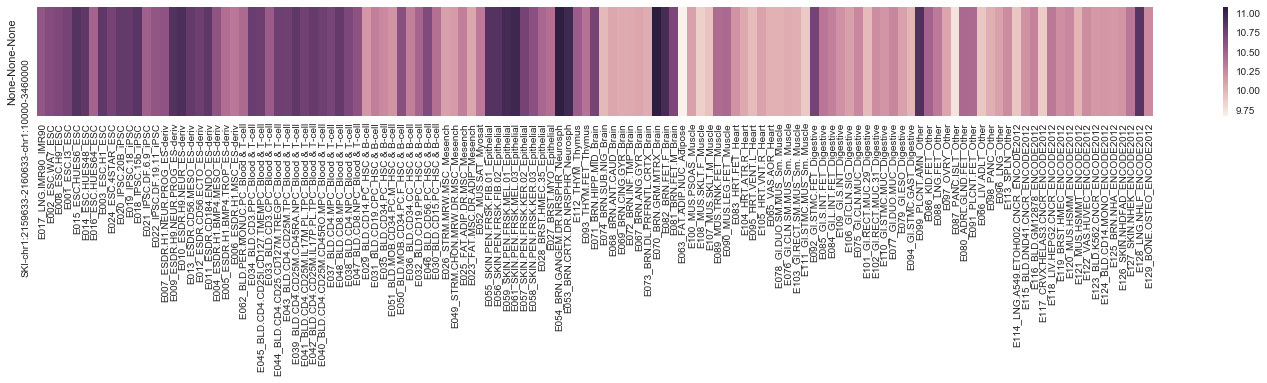

In [3]:
plt.figure(figsize=(25,2))
sns.heatmap(gv.goi.to_frame().transpose())

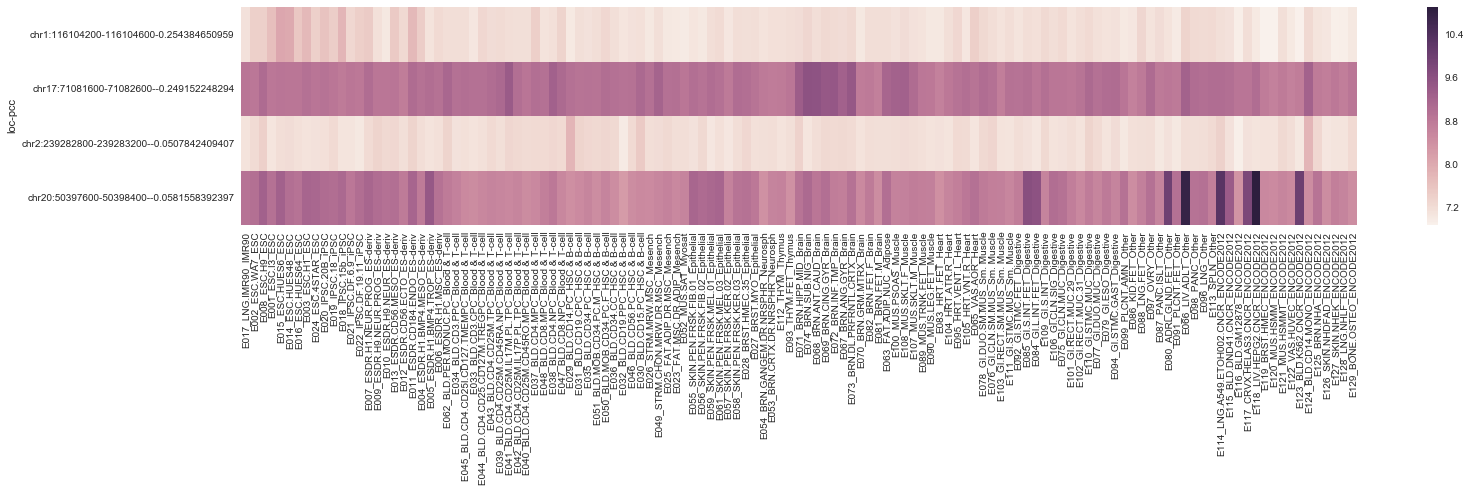

In [4]:
plt.figure(figsize=(25,4))
sns.heatmap( gv.df_dhss)

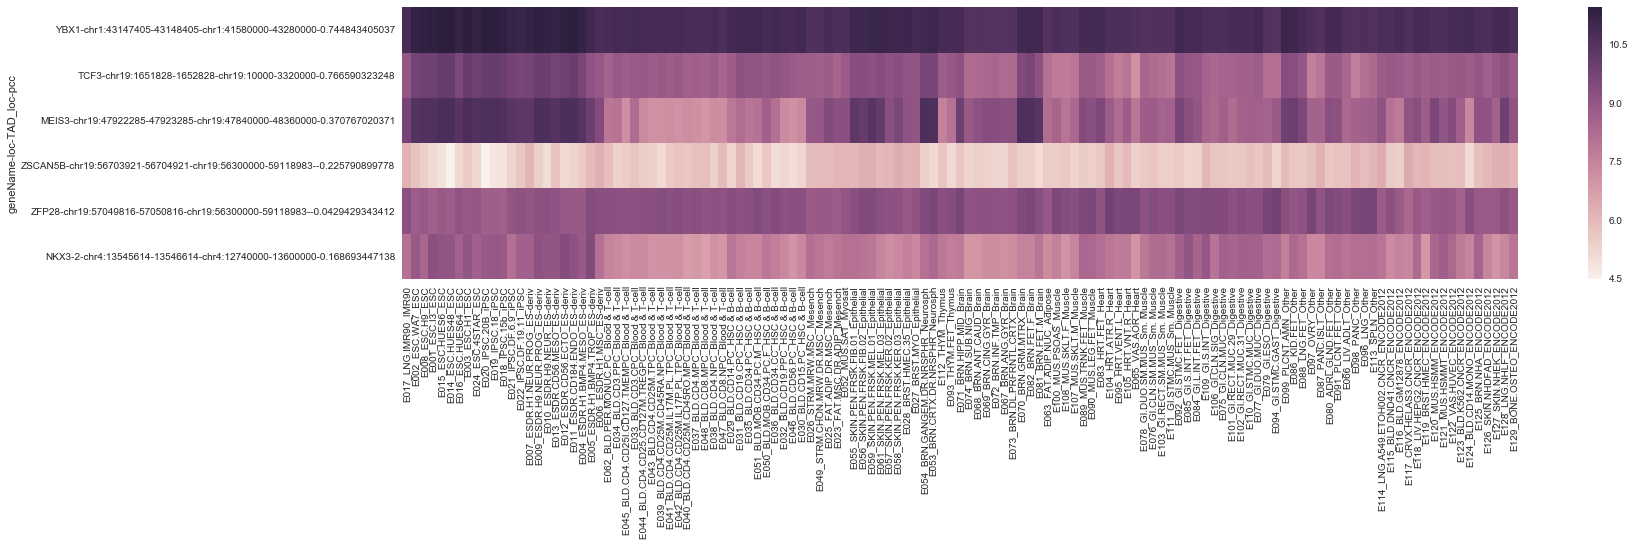

In [5]:
plt.figure(figsize=(25,5))
sns.heatmap(gv.df_tfs)

In [6]:
'''Run HPO on differen train/test splits'''
mp = Model_preparation(gv)
start_time = time.time()

2018-01-27 12:54:27,484: prep_for_model_for_git: INFO    : Preparing the dataframe for train/test splits..


In [7]:
for amode in ["dhss", "tfs", "joint"]:
    tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx, mode=amode)
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials,
                                space=get_parameter_space_forHPO(tm.trainX),
                                algo=tpe_method, max_evals=8)

    index = np.argmin(trials.losses())
    to_log = tm.get_log_into_to_save(index, trials, best_params, mode=amode)
    print(to_log)  #logger.info(to_log)
    title_info = re.split(";best_params", to_log)[0]  # "title" refers to plot_title
    title_prefix, title_error_msg, title_suffix = re.split(";median_pc_error|;PCC", title_info)  # note title_prefix already has the "mode" info
    title_info = title_prefix + "\nmed_pc_err" + title_error_msg + "\nPCC" + title_suffix
    plot_title = "{};{}".format(gv.gene_ofInterest, title_info)
    tm.plot_scatter_performance(amode, index, trials, gv, plot_title=plot_title)

    # Now retrain using the validation set
    wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2 = tm.get_params_from_best_trial(index, trials, best_params)  # nn_updates is the new dict, not the one in tf_model class
    updates = tm.retrain_tensorflow_nn(wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2)
    to_log, plot_title = tm.get_log_info_to_save_after_retraining(trainY, updates, title_prefix=title_prefix)  # title prefix only has mode, test group, and testX.shape infos
    print(to_log)  # logger.info(to_log)
    plot_title = "{};{}".format(gv.gene_ofInterest, plot_title)
    tm.plot_performance_after_retraining(amode, gv, updates, trainY, plot_title=plot_title)

    del tm, trials, best_params
    print("done with mode:", amode)

lamda:2e-05, layer_sizes:[2, 2], loss:0.062191683799, status:ok, yhat_test:[ 0.98736054  0.97264737]
lamda:2e-06, layer_sizes:[2, 2], loss:0.0648161247373, status:ok, yhat_test:[ 0.98759604  0.97923535]
lamda:0.0002, layer_sizes:[3], loss:0.0891706496477, status:ok, yhat_test:[ 0.7987048   0.78366786]
lamda:2e-05, layer_sizes:[3], loss:0.111090630293, status:ok, yhat_test:[ 0.86066234  0.85504854]
lamda:0.2, layer_sizes:[3, 2], loss:0.234219789505, status:ok, yhat_test:[ 0.75878054  0.75878066]
lamda:0.2, layer_sizes:[2, 3], loss:0.190618395805, status:ok, yhat_test:[ 0.80835968  0.80835372]
lamda:2e-07, layer_sizes:[3, 3], loss:0.0666867494583, status:ok, yhat_test:[ 0.9974432   0.96762568]
lamda:0.002, layer_sizes:[2, 2], loss:0.0599739067256, status:ok, yhat_test:[ 0.96929437  0.96934187]
mode:dhss;test_group_17:Thymus;testX.shape:(2, 4);median_pc_error:0.028,0.052,0.026;rmse:0.040,0.051,0.026;PCC:0.008,0.010,nan;SCC:0.325,0.100,nan;best_params:{'layers':1,'lamda':3.0,'n_units_layer

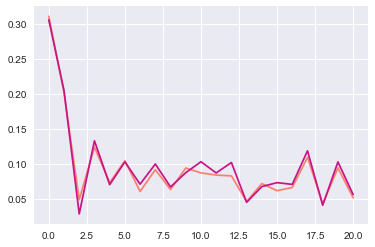

In [8]:
plt.plot(updates["train_loss"], color="salmon")
plt.plot(updates["test_loss"], color="mediumvioletred")

In [9]:
# - EOF - 

```python
# SINCE LAST COMMIT

'''Run HPO on differen train/test splits'''
tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx, mode = "joint")  # mode should be one of "dhss", "tfs", "joint"

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
sns.heatmap(tm.trainX, vmin=0, vmax=1)
plt.title('trainX')
plt.subplot(2, 2, 2)
sns.heatmap(tm.trainY, vmin=0, vmax=1)
plt.title('trainY')

plt.subplot(2, 2, 3)
sns.heatmap(tm.testX, vmin=0, vmax=1)
plt.title('testX')

plt.subplot(2, 2, 4)
sns.heatmap(tm.testY, vmin=0, vmax=1)
plt.title('testY')
plt.suptitle("{}, test_idx:{}".format(gv.gene_ofInterest, test_idx))

'''Now train and search for HPO'''
trials = hyperopt.Trials()
best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials,
                            space=get_parameter_space_forHPO(tm.trainX),
                            algo=tpe_method, max_evals=10)
index = np.argmin(trials.losses())
to_log = tm.get_log_into_to_save(index, trials, best_params)
plot_title = re.split(";best_params", to_log)[0]
plot_title_prefix, plot_title_error_msg, plot_title_suffix = re.split(";median_pc_error|;PCC", plot_title)
plot_title = plot_title_prefix + "\nmed_pc_err" + plot_title_error_msg + "\nPCC" + plot_title_suffix
tm.plot_scatter_performance(trials, gv, gv.gene_ofInterest + ";" + plot_title)

print("Total time taken: {}".format(time.time() - start_time))

index = np.argmin(trials.losses())
plt.plot(trials.results[index]["train_loss"], color="salmon")
plt.plot(trials.results[index]["val_loss"], color="mediumvioletred")

index = np.argmin(trials.losses())
wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2 = tm.get_params_from_best_trial(index, trials, best_params)
updates = tm.retrain_tensorflow_nn(wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2)
tm.plot_performance_after_retraining(gv, updates, trainY, title_prefix=plot_title_prefix)  # need to pass in the title_prefix
```